<a href="https://colab.research.google.com/github/selcuk-yalcin/Convolutional-Neural-Network/blob/main/CNN_vs_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [9]:
# 1. Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [28]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(128 * 3 * 3, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [33]:

# -------------------- Model 2: Mini ResNet with Residual Blocks --------------------
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)

class MiniResNet(nn.Module):
    def __init__(self):
        super(MiniResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.resblock1 = ResidualBlock(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.resblock2 = ResidualBlock(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.resblock3 = ResidualBlock(128)

        self.fc = nn.Linear(128 * 3 * 3, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.resblock1(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.resblock2(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.resblock3(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [34]:
# -------------------- Training Function --------------------
def train_model(model, loader, epochs=10):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    losses, accs = [], []

    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        model.train()
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            # Ensure images have 3 channels
            if images.shape[1] == 1:
                images = images.repeat(1, 3, 1, 1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        losses.append(total_loss / len(loader))
        accs.append(acc)
        scheduler.step()
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss:.3f}, Acc: {acc:.2f}%")
    return losses, accs

In [35]:
# -------------------- Train both models --------------------
print("\n=== Training SimpleCNN ===")
cnn = SimpleCNN()
cnn_loss, cnn_acc = train_model(cnn, train_loader, epochs=10)

print("\n=== Training MiniResNet ===")
resnet = MiniResNet()
resnet_loss, resnet_acc = train_model(model=resnet, loader=train_loader, epochs=10)


=== Training SimpleCNN ===
Epoch [1/10] Loss: 80.652, Acc: 65.74%
Epoch [2/10] Loss: 45.421, Acc: 78.74%
Epoch [3/10] Loss: 39.557, Acc: 82.30%
Epoch [4/10] Loss: 34.559, Acc: 84.42%
Epoch [5/10] Loss: 31.050, Acc: 86.16%
Epoch [6/10] Loss: 27.406, Acc: 88.18%
Epoch [7/10] Loss: 26.088, Acc: 88.30%
Epoch [8/10] Loss: 24.079, Acc: 89.08%
Epoch [9/10] Loss: 22.659, Acc: 89.80%
Epoch [10/10] Loss: 22.133, Acc: 90.48%

=== Training MiniResNet ===
Epoch [1/10] Loss: 55.763, Acc: 74.84%
Epoch [2/10] Loss: 30.885, Acc: 85.64%
Epoch [3/10] Loss: 26.890, Acc: 87.72%
Epoch [4/10] Loss: 19.669, Acc: 90.58%
Epoch [5/10] Loss: 16.770, Acc: 92.08%
Epoch [6/10] Loss: 9.108, Acc: 95.90%
Epoch [7/10] Loss: 4.387, Acc: 98.24%
Epoch [8/10] Loss: 5.686, Acc: 97.50%
Epoch [9/10] Loss: 2.565, Acc: 99.06%
Epoch [10/10] Loss: 1.840, Acc: 99.12%


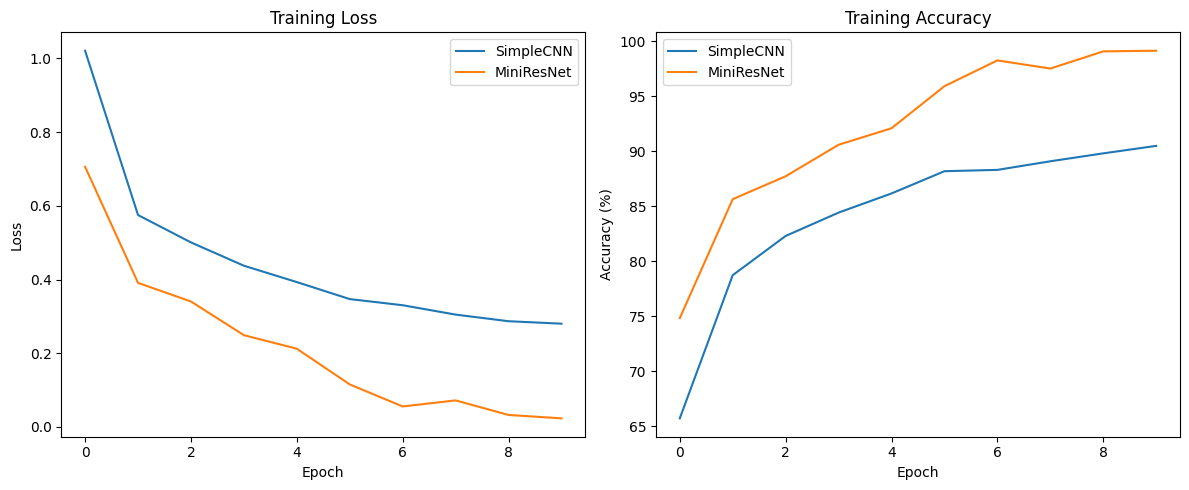

In [36]:
# -------------------- Plot comparison --------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(cnn_loss, label='SimpleCNN')
plt.plot(resnet_loss, label='MiniResNet')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(cnn_acc, label='SimpleCNN')
plt.plot(resnet_acc, label='MiniResNet')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()